Here we train the convolutional neural network with hyperparameter tuning.

What we first do is filter the data into training, test and validation sets. 

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
import PIL
import seaborn as sns
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from functools import partial

c:\Users\Frank\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We filter the data into train/val/test in ratio 80|10|10.

In [2]:
labeling = pd.read_csv('./labels_upsampled.csv')
labeling

filename  item_type       label
0                        100_i110.png        100     plastic
1                        100_i120.png        100     plastic
2                        100_i130.png        100     plastic
3                        100_i140.png        100     plastic
4                        100_i150.png        100     plastic
...                               ...        ...         ...
19639          327_i140_aug_x1995.png        327  wood,paper
19640          364_i180_aug_x1996.png        364  wood,paper
19641  219_i160_aug1430_aug_x1997.png        219  wood,paper
19642  878_i250_aug2203_aug_x1998.png        878  wood,paper
19643  768_i160_aug2387_aug_x1999.png        768  wood,paper

[19644 rows x 3 columns]

In [3]:
source_dir = './DataFilteredPlural/'
target_dir = './trainvaltest/'

Training via Convolutional Neural Network:
But first we need to load the data into dataloaders

In [4]:
#frequency of each class in train/val/test
train_freq = {"metal": 0, "plastic": 0, "wood,paper": 0}
val_freq = {"metal": 0, "plastic": 0, "wood,paper": 0}
test_freq = {"metal": 0, "plastic": 0, "wood,paper": 0}

for file in os.listdir(target_dir + "train"):
    material_type = labeling[labeling['filename'] == file]['label'].values[0]
    train_freq[material_type] += 1
for file in os.listdir(target_dir + "val"):
    material_type = labeling[labeling['filename'] == file]['label'].values[0]
    val_freq[material_type] += 1
for file in os.listdir(target_dir + "test"):
    material_type = labeling[labeling['filename'] == file]['label'].values[0]
    test_freq[material_type] += 1


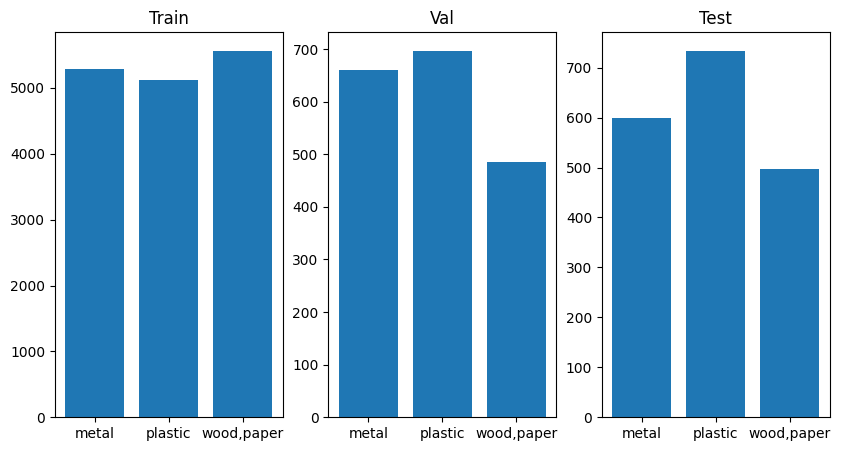

In [5]:
#plot frequency of each class in train/val/test
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.bar(train_freq.keys(), train_freq.values())
plt.title("Train")
plt.subplot(1, 3, 2)
plt.bar(val_freq.keys(), val_freq.values())
plt.title("Val")
plt.subplot(1, 3, 3)
plt.bar(test_freq.keys(), test_freq.values())
plt.title("Test")
plt.show()

In [6]:
#calculate the factor to balance the dataset
ratio = 1/3
metal_factor = 1 / (train_freq["metal"]) * len(os.listdir(target_dir + "train")) * ratio
plastic_factor = 1 / (train_freq["plastic"]) * len(os.listdir(target_dir + "train")) * ratio
wood_paper_factor = 1 / (train_freq["wood,paper"]) * len(os.listdir(target_dir + "train")) * ratio
print("metal_factor: ", metal_factor)
print("plastic_factor: ", plastic_factor)
print("wood_paper_factor: ", wood_paper_factor)

metal_factor:  1.0067448310640443
plastic_factor:  1.0403882483225848
wood_paper_factor:  0.9564618517187686


In [7]:
#custom dataset class
class Top4Dataset(Dataset):
    def __init__(self, csv_file, root_dir, label, transform=None):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(csv_file)
        self.transform = transform
        self.image_names = os.listdir(root_dir)
        self.label = label
    def __len__(self):
        return len(self.image_names)
    
    def __items_class__(self):
        return self.label
    def __getitem__(self, index):
        img_name = self.image_names[index]
        img_path = os.path.join(self.root_dir, img_name)
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        image = image.float()
        material_name = self.annotations[self.annotations["filename"] == img_name]["label"].values[0]
        y_label = [0.0, 0.0, 0.0]
        y_label[self.label[material_name]] = 1.0
        y_label = torch.tensor(y_label)
        path = img_name
        return (image, y_label, path)

In [8]:
material_label = {"metal": 0, "plastic": 1, "wood,paper": 2}

In [9]:
#data transforms
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((144,144)),
    transforms.ToTensor(),
])

In [10]:
csv_file_label = "C:/Users/Frank/Documents/GitHub/AI_V2/convnetupsample_Plural/labels_upsampled.csv"

In [11]:
Top4Dataset_train = Top4Dataset(csv_file=csv_file_label, root_dir=target_dir + "train/", label=material_label, transform=data_transforms)
Top4Dataset_val = Top4Dataset(csv_file=csv_file_label, root_dir=target_dir + "val/", label=material_label, transform=data_transforms)
Top4Dataset_test = Top4Dataset(csv_file=csv_file_label, root_dir=target_dir + "test/", label=material_label, transform=data_transforms)

print(f"length of train dataset: {len(Top4Dataset_train)}")
print(f"length of val dataset: {len(Top4Dataset_val)}")
print(f"length of test dataset: {len(Top4Dataset_test)}")

length of train dataset: 15971
length of val dataset: 1843
length of test dataset: 1830


In [12]:
def load_data(data_dir):
    train_dataset = Top4Dataset(csv_file=csv_file_label, root_dir=data_dir + "train/", label=material_label, transform=data_transforms)
    val_dataset = Top4Dataset(csv_file=csv_file_label, root_dir=data_dir + "val/", label=material_label, transform=data_transforms)
    test_dataset = Top4Dataset(csv_file=csv_file_label, root_dir=data_dir + "test/", label=material_label, transform=data_transforms)
    return train_dataset, val_dataset, test_dataset

In [13]:
batch_count = 8

In [14]:
DataLoader_train = DataLoader(dataset=Top4Dataset_train, batch_size=batch_count, shuffle=True)
DataLoader_val = DataLoader(dataset=Top4Dataset_val, batch_size=batch_count, shuffle=True)
DataLoader_test = DataLoader(dataset=Top4Dataset_test, batch_size=batch_count, shuffle=True)

In [15]:
label_list = ['metal', 'plastic', 'wood,paper']
DataLoader_train.dataset.__items_class__()

{'metal': 0, 'plastic': 1, 'wood,paper': 2}

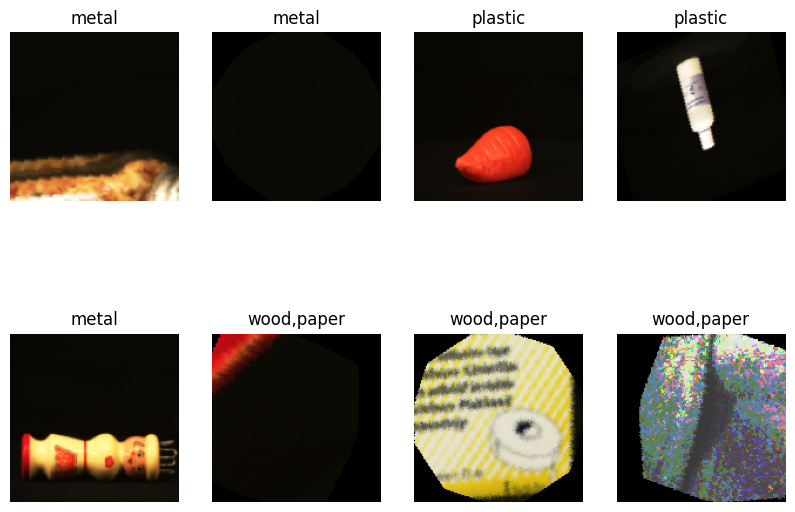

In [16]:
#show images
data = next(iter(DataLoader_train))
images, labels, path = data
plt.figure(figsize=(10, 15))
for i in range(batch_count):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title(label_list[labels[i].argmax()])
    plt.axis("off")

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class ConvNeuralNetwork(nn.Module):
    def __init__(self, c1_out=16, c2_out=25, c1_kernel=3, c2_kernel=3, c1_stride=1, c2_stride=2, dropout=0.1):
        super().__init__()
        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(3, c1_out, kernel_size=c1_kernel, stride=c1_stride, padding= 1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size= 2, stride=2),
            nn.Conv2d(c1_out, c2_out, kernel_size=c2_kernel, stride=c2_stride, padding= 1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size= 2, stride=2),
        )
        self.flatten = nn.Flatten()
        s = self.flatten_counter()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(s, 3),
            nn.LeakyReLU(),
        )

    def forward(self, x):
        logits = nn.functional.normalize(x)
        logits = self.conv_relu_stack(x)
        logits = self.flatten(logits)
        logits = self.linear_relu_stack(logits)
        return logits

    def flatten_counter(self):
        x = torch.rand(1, 3, 144, 144)
        logits = self.conv_relu_stack(x)
        logits = self.flatten(logits)
        return logits.shape[1]


Using cuda device


In [18]:
#convolutionlayer number of parameters
input_size = (3, 144, 144)
in_channels = 3
out_channels = 16
kernel_size = 3
stride = 1
padding = 1
number_of_parameters = (in_channels * out_channels * kernel_size * kernel_size) + out_channels
test = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
print(f"number of parameters: {number_of_parameters}")
print(f"number of parameters: {test.weight.numel() + test.bias.numel()}")

number of parameters: 448
number of parameters: 448


In [19]:
def test(dataloader, model, loss_fn):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for (X, y, z) in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

In [20]:
def train_cifar(config, checkpoint_dir = None, data_dir = None):
    net = ConvNeuralNetwork(c1_out=config["c1_out"], c2_out=config["c2_out"], c1_kernel=config["c1_kernel"], c2_kernel=config["c2_kernel"], c1_stride=config["c1_stride"], c2_stride=config["c2_stride"], dropout=config["dropout"])
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using {device} device")
    net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=config["lr"], momentum=config["momentum"])

    #trail name
    trail_name = f"trail_{config['c1_out']}_{config['c2_out']}_{config['c1_kernel']}_{config['c2_kernel']}_{config['c1_stride']}_{config['c2_stride']}_{config['dropout']}_{config['lr']}_{config['momentum']}"

    train_dataset, val_dataset, test_dataset = load_data(data_dir)
    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=True)

    #chart data
    char_df = pd.DataFrame(columns=["epoch", "train_loss", "test_loss"])

    for epoch in range(config["epochs"]):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels, path = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.argmax(dim=1))
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 50 == 49:    # print every 50 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 50))
                running_loss = 0.0
        avg_testloss = test(test_loader, net, criterion)
        char_df = char_df.append({"epoch": epoch, "train_loss": loss.item(), "test_loss": avg_testloss}, ignore_index=True)
        print("Saving checkpoint")
        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)
        tune.report(loss=avg_testloss, accuracy=avg_testloss, epoch=epoch, checkpoint=path, config=config)
    char_df.to_csv("C:/Users/Frank/Documents/GitHub/AI_V2/convnetupsample_Plural/checkpoint/" + char_name, index=False)    
    print('Finished Training')


In [21]:
weight = [metal_factor, plastic_factor, wood_paper_factor]
DataLoader_train.dataset.label

{'metal': 0, 'plastic': 1, 'wood,paper': 2}

In [22]:
data_dir = "C:/Users/Frank/Documents/GitHub/AI_V2/convnetupsample_Plural/trainvaltest/"

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
config = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "momentum": tune.uniform(0.1, 0.9),
    "batch_size": tune.choice([4, 8, 16, 32, 64]),
    "epochs": 50,
    "c1_out": tune.choice([16, 32, 64]),
    "c2_out": tune.choice([16, 32, 64]),
    "c1_kernel": tune.choice([3, 5, 7]),
    "c2_kernel": tune.choice([3, 5, 7]),
    "c1_stride": tune.choice([1, 2, 3]),
    "c2_stride": tune.choice([1, 2, 3]),
    "c1_pool_kernel": tune.choice([2, 3, 4]),
    "c2_pool_kernel": tune.choice([2, 3, 4]),
    "dropout": tune.uniform(0.1, 0.5),
}
train_dataset, val_dataset, test_dataset = load_data(data_dir)
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    grace_period=1,
    reduction_factor=2)
reporter = CLIReporter(
    parameter_columns=["c1_out", "c2_out", "c1_kernel", "c2_kernel", "c1_stride", "c2_stride", "c1_pool_kernel", "c2_pool_kernel", "dropout", "lr", "momentum", "batch_size", "epochs"],
    metric_columns=["loss", "accuracy", "training_iteration"])
result = tune.run(
    partial(train_cifar, data_dir=data_dir, checkpoint_dir=True),
    resources_per_trial={"cpu": 6, "gpu": 1},
    config=config,
    num_samples= 10,
    scheduler=scheduler,
    progress_reporter=reporter)

best_trial = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(
    best_trial.last_result["accuracy"]))

best_trained_model = ConvNeuralNetwork(c1_out=best_trial.config["c1_out"], c2_out=best_trial.config["c2_out"], c1_kernel=best_trial.config["c1_kernel"], c2_kernel=best_trial.config["c2_kernel"], c1_stride=best_trial.config["c1_stride"], c2_stride=best_trial.config["c2_stride"], dropout=best_trial.config["dropout"])
best_trained_model.to(device)

2023-01-04 00:40:28,757	INFO worker.py:1538 -- Started a local Ray instance.
c:\Users\Frank\anaconda3\envs\torch\lib\site-packages\ray\tune\trainable\function_trainable.py:610: DeprecationWarning: `checkpoint_dir` in `func(config, checkpoint_dir)` is being deprecated. To save and load checkpoint in trainable functions, please use the `ray.air.session` API:

from ray.air import session

def train(config):
    # ...
    session.report({"metric": metric}, checkpoint=checkpoint)

For more information please see https://docs.ray.io/en/master/tune/api_docs/trainable.html

  warnings.warn(


== Status ==
Current time: 2023-01-04 00:40:32 (running for 00:00:00.23)
Memory usage on this node: 9.9/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------+-----------+-------------+------------+--------------+----------+
| Trial name              | status   | loc            |   c1_out |   c2_out |   c1_kernel |   c2_kernel |   c1_stride |   c2_stride |   c1_pool_kernel |   c2_pool_kernel |   dropout |          lr |   momentum |   batch_size |   epochs |
|------------------------

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 50.6%, Avg loss: 1.018095 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [2,    50] loss: 1.055
(func pid=6884) [2,   100] loss: 1.073
(func pid=6884) [2,   150] loss: 1.049
== Status ==
Current time: 2023-01-04 00:41:52 (running for 00:01:20.71)
Memory usage on this node: 12.6/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------+-----------+-------------+------------+--------------+--------

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) [3,    50] loss: 1.000
(func pid=6884) [3,   100] loss: 0.994
(func pid=6884) [3,   150] loss: 1.002
== Status ==
Current time: 2023-01-04 00:42:56 (running for 00:02:24.49)
Memory usage on this node: 12.5/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------+-----------+-------------+------------+--------------+----------+----------+------------+----------------------+
| Trial name              | status   | loc            |   c1_out |  

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 52.0%, Avg loss: 0.997044 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [4,    50] loss: 0.932
(func pid=6884) [4,   100] loss: 0.938
(func pid=6884) [4,   150] loss: 0.908
== Status ==
Current time: 2023-01-04 00:44:00 (running for 00:03:27.84)
Memory usage on this node: 12.6/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------+-----------+-------------+------------+--------

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 53.4%, Avg loss: 0.956413 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [5,    50] loss: 0.919
(func pid=6884) [5,   100] loss: 0.905
(func pid=6884) [5,   150] loss: 0.883
== Status ==
Current time: 2023-01-04 00:45:04 (running for 00:04:31.88)
Memory usage on this node: 12.7/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------+-----------+-------------+------

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 56.0%, Avg loss: 0.952696 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [6,    50] loss: 0.849
(func pid=6884) [6,   100] loss: 0.869
== Status ==
Current time: 2023-01-04 00:46:07 (running for 00:05:35.59)
Memory usage on this node: 13.5/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------+-----------+-------------+------------+--------------+----------+------

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 57.8%, Avg loss: 0.924473 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [7,    50] loss: 0.796
(func pid=6884) [7,   100] loss: 0.810
== Status ==
Current time: 2023-01-04 00:47:20 (running for 00:06:48.36)
Memory usage on this node: 13.5/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------+-----------+-------------+------------+--------------+----------+------

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 61.0%, Avg loss: 0.905012 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [8,    50] loss: 0.790
(func pid=6884) [8,   100] loss: 0.729
(func pid=6884) [8,   150] loss: 0.757
== Status ==
Current time: 2023-01-04 00:48:28 (running for 00:07:56.40)
Memory usage on this node: 13.4/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------+-----------+-------------+------

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 58.8%, Avg loss: 0.954023 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [9,    50] loss: 0.722
(func pid=6884) [9,   100] loss: 0.694
(func pid=6884) [9,   150] loss: 0.745
== Status ==
Current time: 2023-01-04 00:49:39 (running for 00:09:07.40)
Memory usage on this node: 13.5/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------+-----------+-----

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 59.8%, Avg loss: 0.961335 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [10,    50] loss: 0.616
(func pid=6884) [10,   100] loss: 0.672
(func pid=6884) [10,   150] loss: 0.723
== Status ==
Current time: 2023-01-04 00:50:49 (running for 00:10:17.47)
Memory usage on this node: 13.5/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------+-----------+--

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 57.7%, Avg loss: 1.016130 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [11,    50] loss: 0.666
(func pid=6884) [11,   100] loss: 0.625
(func pid=6884) [11,   150] loss: 0.621
== Status ==
Current time: 2023-01-04 00:51:59 (running for 00:11:27.27)
Memory usage on this node: 13.5/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------+-----------+--

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 58.7%, Avg loss: 1.011343 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [12,    50] loss: 0.630
(func pid=6884) [12,   100] loss: 0.646
(func pid=6884) [12,   150] loss: 0.612
== Status ==
Current time: 2023-01-04 00:53:10 (running for 00:12:38.58)
Memory usage on this node: 13.5/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------+-----------+--

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 55.7%, Avg loss: 1.052724 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [13,    50] loss: 0.581
(func pid=6884) [13,   100] loss: 0.585
== Status ==
Current time: 2023-01-04 00:54:24 (running for 00:13:52.00)
Memory usage on this node: 13.5/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------+-----------+-------------+------------+--------------+

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 54.3%, Avg loss: 1.168531 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [14,    50] loss: 0.539
(func pid=6884) [14,   100] loss: 0.533
(func pid=6884) [14,   150] loss: 0.536
== Status ==
Current time: 2023-01-04 00:55:38 (running for 00:15:05.91)
Memory usage on this node: 13.5/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------+-----------+--

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 58.6%, Avg loss: 1.010595 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [15,    50] loss: 0.558
(func pid=6884) [15,   100] loss: 0.517
(func pid=6884) [15,   150] loss: 0.529
== Status ==
Current time: 2023-01-04 00:56:52 (running for 00:16:20.04)
Memory usage on this node: 13.6/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------+-----------+--

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 59.6%, Avg loss: 1.049795 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [16,    50] loss: 0.491
(func pid=6884) [16,   100] loss: 0.549
== Status ==
Current time: 2023-01-04 00:58:07 (running for 00:17:34.84)
Memory usage on this node: 13.7/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------+-----------+-------------+------------+--------------+

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 56.1%, Avg loss: 1.154675 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [17,    50] loss: 0.558
(func pid=6884) [17,   100] loss: 0.486
(func pid=6884) [17,   150] loss: 0.423
== Status ==
Current time: 2023-01-04 00:59:17 (running for 00:18:45.44)
Memory usage on this node: 13.7/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 58.7%, Avg loss: 1.184503 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [18,    50] loss: 0.488
(func pid=6884) [18,   100] loss: 0.539
== Status ==
Current time: 2023-01-04 01:00:26 (running for 00:19:54.05)
Memory usage on this node: 13.8/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------+-----------+-------------+------------+

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 55.9%, Avg loss: 1.254095 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [19,    50] loss: 0.452
(func pid=6884) [19,   100] loss: 0.391
== Status ==
Current time: 2023-01-04 01:01:37 (running for 00:21:05.08)
Memory usage on this node: 13.7/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------+-----------+-------------+------------+

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 52.7%, Avg loss: 1.454576 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [20,    50] loss: 0.416
(func pid=6884) [20,   100] loss: 0.398
(func pid=6884) [20,   150] loss: 0.408
== Status ==
Current time: 2023-01-04 01:02:47 (running for 00:22:15.65)
Memory usage on this node: 13.6/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 54.8%, Avg loss: 1.372855 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [21,    50] loss: 0.440
(func pid=6884) [21,   100] loss: 0.394
(func pid=6884) [21,   150] loss: 0.362
== Status ==
Current time: 2023-01-04 01:03:53 (running for 00:23:20.87)
Memory usage on this node: 12.6/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 60.8%, Avg loss: 1.240896 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [22,    50] loss: 0.412
(func pid=6884) [22,   100] loss: 0.373
(func pid=6884) [22,   150] loss: 0.389
== Status ==
Current time: 2023-01-04 01:05:01 (running for 00:24:29.62)
Memory usage on this node: 12.7/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 54.8%, Avg loss: 1.383110 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [23,    50] loss: 0.368
(func pid=6884) [23,   100] loss: 0.381
(func pid=6884) [23,   150] loss: 0.415
== Status ==
Current time: 2023-01-04 01:06:08 (running for 00:25:36.52)
Memory usage on this node: 13.3/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 56.0%, Avg loss: 1.355873 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [24,    50] loss: 0.369
(func pid=6884) [24,   100] loss: 0.417
(func pid=6884) [24,   150] loss: 0.382
== Status ==
Current time: 2023-01-04 01:07:12 (running for 00:26:40.59)
Memory usage on this node: 13.2/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 58.3%, Avg loss: 1.552290 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [25,    50] loss: 0.288
(func pid=6884) [25,   100] loss: 0.363
(func pid=6884) [25,   150] loss: 0.333
== Status ==
Current time: 2023-01-04 01:08:19 (running for 00:27:46.94)
Memory usage on this node: 13.6/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 61.6%, Avg loss: 1.308572 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [26,    50] loss: 0.337
(func pid=6884) [26,   100] loss: 0.284
== Status ==
Current time: 2023-01-04 01:09:29 (running for 00:28:56.80)
Memory usage on this node: 13.6/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------+-----------+-------------+------------+

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 58.6%, Avg loss: 1.452387 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [27,    50] loss: 0.364
(func pid=6884) [27,   100] loss: 0.347
(func pid=6884) [27,   150] loss: 0.307
== Status ==
Current time: 2023-01-04 01:10:37 (running for 00:30:05.02)
Memory usage on this node: 13.8/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 56.7%, Avg loss: 1.425082 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [28,    50] loss: 0.373
(func pid=6884) [28,   100] loss: 0.394
(func pid=6884) [28,   150] loss: 0.309
== Status ==
Current time: 2023-01-04 01:11:44 (running for 00:31:11.73)
Memory usage on this node: 13.0/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 59.2%, Avg loss: 1.620529 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [29,    50] loss: 0.299
(func pid=6884) [29,   100] loss: 0.328
(func pid=6884) [29,   150] loss: 0.375
== Status ==
Current time: 2023-01-04 01:12:47 (running for 00:32:15.50)
Memory usage on this node: 12.7/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 57.3%, Avg loss: 1.707198 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [30,    50] loss: 0.360
(func pid=6884) [30,   100] loss: 0.326
(func pid=6884) [30,   150] loss: 0.261
== Status ==
Current time: 2023-01-04 01:13:51 (running for 00:33:18.80)
Memory usage on this node: 12.7/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 54.9%, Avg loss: 1.919136 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [31,    50] loss: 0.288
(func pid=6884) [31,   100] loss: 0.323
(func pid=6884) [31,   150] loss: 0.366
== Status ==
Current time: 2023-01-04 01:14:54 (running for 00:34:22.13)
Memory usage on this node: 12.7/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 54.4%, Avg loss: 1.787864 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [32,    50] loss: 0.280
(func pid=6884) [32,   100] loss: 0.247
(func pid=6884) [32,   150] loss: 0.247
== Status ==
Current time: 2023-01-04 01:15:57 (running for 00:35:25.53)
Memory usage on this node: 12.7/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 56.0%, Avg loss: 1.730499 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [33,    50] loss: 0.258
(func pid=6884) [33,   100] loss: 0.316
(func pid=6884) [33,   150] loss: 0.278
== Status ==
Current time: 2023-01-04 01:17:01 (running for 00:36:28.89)
Memory usage on this node: 12.7/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+---

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 57.5%, Avg loss: 1.670713 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [34,    50] loss: 0.300
(func pid=6884) [34,   100] loss: 0.236
(func pid=6884) [34,   150] loss: 0.280
== Status ==
Current time: 2023-01-04 01:18:04 (running for 00:37:32.51)
Memory usage on this node: 12.7/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+---

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 59.1%, Avg loss: 1.654093 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [35,    50] loss: 0.294
(func pid=6884) [35,   100] loss: 0.296
(func pid=6884) [35,   150] loss: 0.269
== Status ==
Current time: 2023-01-04 01:19:15 (running for 00:38:43.57)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+---

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 58.4%, Avg loss: 1.705729 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [36,    50] loss: 0.278
(func pid=6884) [36,   100] loss: 0.243
(func pid=6884) [36,   150] loss: 0.216
== Status ==
Current time: 2023-01-04 01:20:24 (running for 00:39:52.06)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+---

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 56.4%, Avg loss: 1.931355 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [37,    50] loss: 0.247
(func pid=6884) [37,   100] loss: 0.265
(func pid=6884) [37,   150] loss: 0.279
== Status ==
Current time: 2023-01-04 01:21:31 (running for 00:40:59.15)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+---

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 56.1%, Avg loss: 1.958746 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [38,    50] loss: 0.258
(func pid=6884) [38,   100] loss: 0.245
(func pid=6884) [38,   150] loss: 0.265
== Status ==
Current time: 2023-01-04 01:22:35 (running for 00:42:03.55)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+---

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 55.6%, Avg loss: 2.082587 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [39,    50] loss: 0.239
(func pid=6884) [39,   100] loss: 0.263
(func pid=6884) [39,   150] loss: 0.249
== Status ==
Current time: 2023-01-04 01:23:39 (running for 00:43:07.17)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+---

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 58.0%, Avg loss: 1.841328 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [40,    50] loss: 0.213
(func pid=6884) [40,   100] loss: 0.229
(func pid=6884) [40,   150] loss: 0.278
== Status ==
Current time: 2023-01-04 01:24:43 (running for 00:44:11.17)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+---

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 54.5%, Avg loss: 2.334787 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [41,    50] loss: 0.206
(func pid=6884) [41,   100] loss: 0.258
(func pid=6884) [41,   150] loss: 0.206
== Status ==
Current time: 2023-01-04 01:25:46 (running for 00:45:14.60)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+---

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 57.9%, Avg loss: 1.987979 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [42,    50] loss: 0.300
(func pid=6884) [42,   100] loss: 0.300
(func pid=6884) [42,   150] loss: 0.245
== Status ==
Current time: 2023-01-04 01:26:50 (running for 00:46:17.83)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+---

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 54.6%, Avg loss: 2.281764 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [43,    50] loss: 0.208
(func pid=6884) [43,   100] loss: 0.234
(func pid=6884) [43,   150] loss: 0.238
== Status ==
Current time: 2023-01-04 01:27:54 (running for 00:47:21.96)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+---

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 55.3%, Avg loss: 2.235946 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [44,    50] loss: 0.178
(func pid=6884) [44,   100] loss: 0.184
(func pid=6884) [44,   150] loss: 0.282
== Status ==
Current time: 2023-01-04 01:28:57 (running for 00:48:25.17)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+---

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 56.5%, Avg loss: 2.352622 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [45,    50] loss: 0.260
(func pid=6884) [45,   100] loss: 0.242
(func pid=6884) [45,   150] loss: 0.213
== Status ==
Current time: 2023-01-04 01:30:01 (running for 00:49:29.50)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+---

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 56.3%, Avg loss: 2.161516 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [46,    50] loss: 0.265
(func pid=6884) [46,   100] loss: 0.264
(func pid=6884) [46,   150] loss: 0.255
== Status ==
Current time: 2023-01-04 01:31:05 (running for 00:50:33.38)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+---

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 58.3%, Avg loss: 2.151581 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [47,    50] loss: 0.255
(func pid=6884) [47,   100] loss: 0.224
(func pid=6884) [47,   150] loss: 0.224
== Status ==
Current time: 2023-01-04 01:32:09 (running for 00:51:37.21)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+---

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 56.1%, Avg loss: 2.586415 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [48,    50] loss: 0.363
(func pid=6884) [48,   100] loss: 0.243
(func pid=6884) [48,   150] loss: 0.215
== Status ==
Current time: 2023-01-04 01:33:13 (running for 00:52:41.32)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+---

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) [49,    50] loss: 0.188
(func pid=6884) [49,   100] loss: 0.215
(func pid=6884) [49,   150] loss: 0.207
== Status ==
Current time: 2023-01-04 01:34:17 (running for 00:53:45.44)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------+-----------+-------------+------------+--------------+----------+---------+------------+----------------------+
| Tria

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 56.6%, Avg loss: 2.440243 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) [50,    50] loss: 0.221
(func pid=6884) [50,   100] loss: 0.195
(func pid=6884) [50,   150] loss: 0.230
== Status ==
Current time: 2023-01-04 01:35:22 (running for 00:54:49.75)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+---

(func pid=6884) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=6884) Test Error: 
(func pid=6884)  Accuracy: 56.9%, Avg loss: 2.355056 
(func pid=6884) 
(func pid=6884) Saving checkpoint
(func pid=6884) Finished Training
== Status ==
Current time: 2023-01-04 01:36:26 (running for 00:55:53.79)
Memory usage on this node: 10.8/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.018094851200237
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------+-----------+-------------+------------+--------------

(func pid=23824) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=23824) Test Error: 
(func pid=23824)  Accuracy: 49.7%, Avg loss: 1.097722 
(func pid=23824) 
(func pid=23824) Saving checkpoint
(func pid=11384) Using cuda device
== Status ==
Current time: 2023-01-04 01:37:34 (running for 00:57:02.48)
Memory usage on this node: 10.8/32.0 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0579083352100775
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------+-----------+-------------+------------+--------

(func pid=11384) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11384) Test Error: 
(func pid=11384)  Accuracy: 40.1%, Avg loss: 1.096017 
(func pid=11384) 
(func pid=11384) Saving checkpoint
(func pid=21764) Using cuda device
== Status ==
Current time: 2023-01-04 01:39:08 (running for 00:58:36.39)
Memory usage on this node: 10.8/32.0 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0960173938585365
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------+-----------+-------------+------------+--------

(func pid=21764) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=21764) Test Error: 
(func pid=21764)  Accuracy: 44.8%, Avg loss: 1.075603 
(func pid=21764) 
(func pid=21764) Saving checkpoint
== Status ==
Current time: 2023-01-04 01:40:12 (running for 00:59:40.08)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0858099934758096
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------+-----------+-------------+------------+--------------+----------+---------+-------

(func pid=21764) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=21764) Test Error: 
(func pid=21764)  Accuracy: 51.0%, Avg loss: 1.012875 
(func pid=21764) 
(func pid=21764) Saving checkpoint
(func pid=11236) Using cuda device
== Status ==
Current time: 2023-01-04 01:41:08 (running for 01:00:36.60)
Memory usage on this node: 10.8/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9849240954849237 | Iter 1.000: -1.0858099934758096
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------+-----------+-------------+------------+--------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 53.7%, Avg loss: 0.986179 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [2,    50] loss: 1.007
(func pid=11236) [2,   100] loss: 1.033
(func pid=11236) [2,   150] loss: 1.036
== Status ==
Current time: 2023-01-04 01:42:25 (running for 01:01:52.88)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9849240954849237 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+-------------+

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 53.7%, Avg loss: 0.952396 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [3,    50] loss: 0.963
(func pid=11236) [3,   100] loss: 0.974
(func pid=11236) [3,   150] loss: 0.980
== Status ==
Current time: 2023-01-04 01:43:34 (running for 01:03:02.09)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+-------------+

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 58.5%, Avg loss: 0.884315 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [4,    50] loss: 0.879
(func pid=11236) [4,   100] loss: 0.937
(func pid=11236) [4,   150] loss: 0.922
== Status ==
Current time: 2023-01-04 01:44:44 (running for 01:04:11.86)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+-------------+

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 57.6%, Avg loss: 0.892298 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [5,    50] loss: 0.891
(func pid=11236) [5,   100] loss: 0.869
(func pid=11236) [5,   150] loss: 0.865
== Status ==
Current time: 2023-01-04 01:45:52 (running for 01:05:20.70)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+-------------+

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 60.3%, Avg loss: 0.891622 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [6,    50] loss: 0.847
(func pid=11236) [6,   100] loss: 0.866
(func pid=11236) [6,   150] loss: 0.865
== Status ==
Current time: 2023-01-04 01:47:01 (running for 01:06:29.70)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+-------------+

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) [7,    50] loss: 0.829
(func pid=11236) [7,   100] loss: 0.796
(func pid=11236) [7,   150] loss: 0.798
== Status ==
Current time: 2023-01-04 01:48:11 (running for 01:07:38.84)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------+-----------+-------------+------------+--------------+----------+----------+------------+-----------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 59.2%, Avg loss: 0.944415 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [8,    50] loss: 0.759
(func pid=11236) [8,   100] loss: 0.734
(func pid=11236) [8,   150] loss: 0.692
== Status ==
Current time: 2023-01-04 01:49:20 (running for 01:08:48.34)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9540229542546917 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+-------------+

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) [9,    50] loss: 0.756
(func pid=11236) [9,   100] loss: 0.761
(func pid=11236) [9,   150] loss: 0.663
== Status ==
Current time: 2023-01-04 01:50:29 (running for 01:09:57.72)
Memory usage on this node: 13.2/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------+-----------+-------------+------------+--------------+----------+----------+------------+-----------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 55.6%, Avg loss: 0.910927 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [10,    50] loss: 0.703
(func pid=11236) [10,   100] loss: 0.725
(func pid=11236) [10,   150] loss: 0.730
== Status ==
Current time: 2023-01-04 01:51:39 (running for 01:11:07.24)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+-----------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 61.0%, Avg loss: 0.912925 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [11,    50] loss: 0.720
(func pid=11236) [11,   100] loss: 0.690
(func pid=11236) [11,   150] loss: 0.645
== Status ==
Current time: 2023-01-04 01:52:48 (running for 01:12:16.43)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+-----------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 60.5%, Avg loss: 0.868743 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [12,    50] loss: 0.608
(func pid=11236) [12,   100] loss: 0.678
(func pid=11236) [12,   150] loss: 0.669
== Status ==
Current time: 2023-01-04 01:53:57 (running for 01:13:25.47)
Memory usage on this node: 13.0/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+-----------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 59.5%, Avg loss: 0.897381 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [13,    50] loss: 0.704
(func pid=11236) [13,   100] loss: 0.604
(func pid=11236) [13,   150] loss: 0.614
== Status ==
Current time: 2023-01-04 01:55:06 (running for 01:14:34.48)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+-----------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 58.7%, Avg loss: 0.896998 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [14,    50] loss: 0.605
(func pid=11236) [14,   100] loss: 0.620
(func pid=11236) [14,   150] loss: 0.558
== Status ==
Current time: 2023-01-04 01:56:15 (running for 01:15:43.61)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+-----------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 58.3%, Avg loss: 0.985204 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [15,    50] loss: 0.604
(func pid=11236) [15,   100] loss: 0.523
(func pid=11236) [15,   150] loss: 0.569
== Status ==
Current time: 2023-01-04 01:57:25 (running for 01:16:52.90)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+-----------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 57.9%, Avg loss: 0.977713 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [16,    50] loss: 0.544
(func pid=11236) [16,   100] loss: 0.520
(func pid=11236) [16,   150] loss: 0.597
== Status ==
Current time: 2023-01-04 01:58:34 (running for 01:18:01.77)
Memory usage on this node: 13.0/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.1546747517247387 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+-----------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 56.4%, Avg loss: 1.062720 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [17,    50] loss: 0.535
(func pid=11236) [17,   100] loss: 0.566
(func pid=11236) [17,   150] loss: 0.566
== Status ==
Current time: 2023-01-04 01:59:43 (running for 01:19:11.38)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+------------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 57.2%, Avg loss: 1.100820 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [18,    50] loss: 0.493
(func pid=11236) [18,   100] loss: 0.520
(func pid=11236) [18,   150] loss: 0.517
== Status ==
Current time: 2023-01-04 02:00:52 (running for 01:20:19.86)
Memory usage on this node: 13.0/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+------------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 58.3%, Avg loss: 1.068925 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [19,    50] loss: 0.507
(func pid=11236) [19,   100] loss: 0.514
(func pid=11236) [19,   150] loss: 0.435
== Status ==
Current time: 2023-01-04 02:02:00 (running for 01:21:28.31)
Memory usage on this node: 13.0/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+------------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 59.5%, Avg loss: 0.960469 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [20,    50] loss: 0.471
(func pid=11236) [20,   100] loss: 0.430
(func pid=11236) [20,   150] loss: 0.454
== Status ==
Current time: 2023-01-04 02:03:08 (running for 01:22:36.26)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+------------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 59.0%, Avg loss: 1.018441 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [21,    50] loss: 0.438
(func pid=11236) [21,   100] loss: 0.454
(func pid=11236) [21,   150] loss: 0.439
== Status ==
Current time: 2023-01-04 02:04:17 (running for 01:23:44.85)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+------------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 57.6%, Avg loss: 1.064822 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [22,    50] loss: 0.358
(func pid=11236) [22,   100] loss: 0.463
(func pid=11236) [22,   150] loss: 0.448
== Status ==
Current time: 2023-01-04 02:05:25 (running for 01:24:53.40)
Memory usage on this node: 13.0/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+------------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 58.3%, Avg loss: 1.126867 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [23,    50] loss: 0.441
(func pid=11236) [23,   100] loss: 0.370
(func pid=11236) [23,   150] loss: 0.438
== Status ==
Current time: 2023-01-04 02:06:34 (running for 01:26:01.77)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+------------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 56.9%, Avg loss: 1.208674 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [24,    50] loss: 0.432
(func pid=11236) [24,   100] loss: 0.423
(func pid=11236) [24,   150] loss: 0.390
== Status ==
Current time: 2023-01-04 02:07:42 (running for 01:27:09.85)
Memory usage on this node: 13.2/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+------------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 56.8%, Avg loss: 1.216100 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [25,    50] loss: 0.352
(func pid=11236) [25,   100] loss: 0.350
(func pid=11236) [25,   150] loss: 0.359
== Status ==
Current time: 2023-01-04 02:08:50 (running for 01:28:18.03)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+------------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 58.6%, Avg loss: 1.221432 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [26,    50] loss: 0.406
(func pid=11236) [26,   100] loss: 0.413
(func pid=11236) [26,   150] loss: 0.329
== Status ==
Current time: 2023-01-04 02:09:58 (running for 01:29:26.40)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+------------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 56.6%, Avg loss: 1.219816 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [27,    50] loss: 0.369
(func pid=11236) [27,   100] loss: 0.381
(func pid=11236) [27,   150] loss: 0.348
== Status ==
Current time: 2023-01-04 02:11:07 (running for 01:30:34.89)
Memory usage on this node: 13.2/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+------------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) [28,    50] loss: 0.332
(func pid=11236) [28,   100] loss: 0.358
(func pid=11236) [28,   150] loss: 0.351
== Status ==
Current time: 2023-01-04 02:12:15 (running for 01:31:43.45)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------+-----------+-------------+------------+--------------+----------+---------+------------+----------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 58.0%, Avg loss: 1.222547 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [29,    50] loss: 0.317
(func pid=11236) [29,   100] loss: 0.346
(func pid=11236) [29,   150] loss: 0.295
== Status ==
Current time: 2023-01-04 02:13:24 (running for 01:32:51.79)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+------------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 59.2%, Avg loss: 1.182641 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [30,    50] loss: 0.281
(func pid=11236) [30,   100] loss: 0.320
(func pid=11236) [30,   150] loss: 0.321
== Status ==
Current time: 2023-01-04 02:14:32 (running for 01:34:00.34)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+------------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 56.4%, Avg loss: 1.317214 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [31,    50] loss: 0.345
(func pid=11236) [31,   100] loss: 0.278
(func pid=11236) [31,   150] loss: 0.356
== Status ==
Current time: 2023-01-04 02:15:39 (running for 01:35:07.11)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+------------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 57.8%, Avg loss: 1.349060 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [32,    50] loss: 0.276
(func pid=11236) [32,   100] loss: 0.349
(func pid=11236) [32,   150] loss: 0.328
== Status ==
Current time: 2023-01-04 02:16:45 (running for 01:36:13.34)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.7304988984978356 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+------------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 56.1%, Avg loss: 1.360739 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [33,    50] loss: 0.263
(func pid=11236) [33,   100] loss: 0.293
(func pid=11236) [33,   150] loss: 0.356
== Status ==
Current time: 2023-01-04 02:17:52 (running for 01:37:19.88)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.5456188425551858 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+------------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 55.8%, Avg loss: 1.409462 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [34,    50] loss: 0.295
(func pid=11236) [34,   100] loss: 0.303
(func pid=11236) [34,   150] loss: 0.308
== Status ==
Current time: 2023-01-04 02:18:58 (running for 01:38:26.42)
Memory usage on this node: 13.2/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.5456188425551858 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+------------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 55.2%, Avg loss: 1.600918 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [35,    50] loss: 0.262
(func pid=11236) [35,   100] loss: 0.247
(func pid=11236) [35,   150] loss: 0.193
== Status ==
Current time: 2023-01-04 02:20:05 (running for 01:39:33.59)
Memory usage on this node: 13.2/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.5456188425551858 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+------------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 55.2%, Avg loss: 1.473548 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [36,    50] loss: 0.249
(func pid=11236) [36,   100] loss: 0.268
(func pid=11236) [36,   150] loss: 0.232
== Status ==
Current time: 2023-01-04 02:21:12 (running for 01:40:39.90)
Memory usage on this node: 13.2/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.5456188425551858 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+------------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 54.2%, Avg loss: 1.663780 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [37,    50] loss: 0.276
(func pid=11236) [37,   100] loss: 0.239
(func pid=11236) [37,   150] loss: 0.243
== Status ==
Current time: 2023-01-04 02:22:18 (running for 01:41:46.43)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.5456188425551858 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+------------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 56.7%, Avg loss: 1.744647 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [38,    50] loss: 0.297
(func pid=11236) [38,   100] loss: 0.234
(func pid=11236) [38,   150] loss: 0.282
== Status ==
Current time: 2023-01-04 02:23:24 (running for 01:42:52.67)
Memory usage on this node: 13.2/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.5456188425551858 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+------------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 57.4%, Avg loss: 1.525992 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [39,    50] loss: 0.254
(func pid=11236) [39,   100] loss: 0.304
(func pid=11236) [39,   150] loss: 0.227
== Status ==
Current time: 2023-01-04 02:24:31 (running for 01:43:59.19)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.5456188425551858 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+------------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 56.5%, Avg loss: 1.735492 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [40,    50] loss: 0.198
(func pid=11236) [40,   100] loss: 0.264
(func pid=11236) [40,   150] loss: 0.303
== Status ==
Current time: 2023-01-04 02:25:37 (running for 01:45:05.69)
Memory usage on this node: 13.2/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.5456188425551858 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+------------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 56.7%, Avg loss: 1.659708 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [41,    50] loss: 0.220
(func pid=11236) [41,   100] loss: 0.238
(func pid=11236) [41,   150] loss: 0.216
== Status ==
Current time: 2023-01-04 02:26:44 (running for 01:46:12.21)
Memory usage on this node: 13.2/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.5456188425551858 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+------------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 54.5%, Avg loss: 1.778404 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [42,    50] loss: 0.213
(func pid=11236) [42,   100] loss: 0.305
(func pid=11236) [42,   150] loss: 0.223
== Status ==
Current time: 2023-01-04 02:27:51 (running for 01:47:19.38)
Memory usage on this node: 13.2/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.5456188425551858 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+------------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 58.6%, Avg loss: 1.615559 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [43,    50] loss: 0.251
(func pid=11236) [43,   100] loss: 0.199
(func pid=11236) [43,   150] loss: 0.208
== Status ==
Current time: 2023-01-04 02:28:57 (running for 01:48:25.42)
Memory usage on this node: 13.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.5456188425551858 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+------------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 58.4%, Avg loss: 1.603974 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [44,    50] loss: 0.170
(func pid=11236) [44,   100] loss: 0.209
(func pid=11236) [44,   150] loss: 0.199
== Status ==
Current time: 2023-01-04 02:30:03 (running for 01:49:30.79)
Memory usage on this node: 13.2/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.5456188425551858 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+------------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 54.0%, Avg loss: 1.794582 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [45,    50] loss: 0.209
(func pid=11236) [45,   100] loss: 0.169
(func pid=11236) [45,   150] loss: 0.186
== Status ==
Current time: 2023-01-04 02:31:08 (running for 01:50:36.09)
Memory usage on this node: 13.3/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.5456188425551858 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+------------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 56.8%, Avg loss: 1.920478 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [46,    50] loss: 0.198
(func pid=11236) [46,   100] loss: 0.210
(func pid=11236) [46,   150] loss: 0.211
== Status ==
Current time: 2023-01-04 02:32:14 (running for 01:51:42.34)
Memory usage on this node: 13.2/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.5456188425551858 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+------------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 55.1%, Avg loss: 1.901983 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [47,    50] loss: 0.165
(func pid=11236) [47,   100] loss: 0.189
(func pid=11236) [47,   150] loss: 0.204
== Status ==
Current time: 2023-01-04 02:33:20 (running for 01:52:48.02)
Memory usage on this node: 13.2/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.5456188425551858 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+------------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 58.5%, Avg loss: 1.752584 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [48,    50] loss: 0.161
(func pid=11236) [48,   100] loss: 0.153
(func pid=11236) [48,   150] loss: 0.179
== Status ==
Current time: 2023-01-04 02:34:26 (running for 01:53:54.28)
Memory usage on this node: 13.2/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.5456188425551858 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+------------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 56.7%, Avg loss: 1.870236 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [49,    50] loss: 0.196
(func pid=11236) [49,   100] loss: 0.191
(func pid=11236) [49,   150] loss: 0.163
== Status ==
Current time: 2023-01-04 02:35:32 (running for 01:54:59.80)
Memory usage on this node: 13.3/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.5456188425551858 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+------------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 55.1%, Avg loss: 2.087829 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) [50,    50] loss: 0.268
(func pid=11236) [50,   100] loss: 0.201
(func pid=11236) [50,   150] loss: 0.196
== Status ==
Current time: 2023-01-04 02:36:38 (running for 01:56:05.83)
Memory usage on this node: 13.2/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.5456188425551858 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+------------

(func pid=11236) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=11236) Test Error: 
(func pid=11236)  Accuracy: 59.0%, Avg loss: 1.857524 
(func pid=11236) 
(func pid=11236) Saving checkpoint
(func pid=11236) Finished Training
== Status ==
Current time: 2023-01-04 02:37:42 (running for 01:57:09.98)
Memory usage on this node: 10.8/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.5456188425551858 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.0756025930930828
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------+-----------+-------------+------------+---------

(func pid=9136) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=9136) Test Error: 
(func pid=9136)  Accuracy: 53.1%, Avg loss: 0.973885 
(func pid=9136) 
(func pid=9136) Saving checkpoint
== Status ==
Current time: 2023-01-04 02:38:40 (running for 01:58:08.39)
Memory usage on this node: 13.4/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.5456188425551858 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9569734972637293 | Iter 1.000: -1.04684872214666
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------+-----------+-------------+------------+--------------+----------+----------+------------+

(func pid=9136) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


== Status ==
Current time: 2023-01-04 02:39:31 (running for 01:58:59.01)
Memory usage on this node: 13.3/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.5456188425551858 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9546849866881641 | Iter 1.000: -1.04684872214666
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------+-----------+-------------+------------+--------------+----------+----------+------------+----------------------+
| Trial name              | status     | loc             |   c1_out |   c2_out |   c1_kernel |   c2_kernel |  

(func pid=9136) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=9136) Test Error: 
(func pid=9136)  Accuracy: 57.4%, Avg loss: 0.923420 
(func pid=9136) 
(func pid=9136) Saving checkpoint
== Status ==
Current time: 2023-01-04 02:40:21 (running for 01:59:49.52)
Memory usage on this node: 13.3/32.0 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: -1.5456188425551858 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9243552294360498 | Iter 2.000: -0.9546849866881641 | Iter 1.000: -1.04684872214666
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------+-----------+-------------+------------+--------------+----------+---------+------------+-

(func pid=9136) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=9136) Test Error: 
(func pid=9136)  Accuracy: 51.0%, Avg loss: 0.958447 
(func pid=9136) 
(func pid=9136) Saving checkpoint
(func pid=1100) Using cuda device
== Status ==
Current time: 2023-01-04 02:41:13 (running for 02:00:41.07)
Memory usage on this node: 11.0/32.0 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 32.000: -1.5456188425551858 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9546849866881641 | Iter 1.000: -1.04684872214666
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------+-----------+-------------+------------+--------------+-

(func pid=1100) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=1100) Test Error: 
(func pid=1100)  Accuracy: 42.8%, Avg loss: 1.049538 
(func pid=1100) 
(func pid=1100) Saving checkpoint
== Status ==
Current time: 2023-01-04 02:42:19 (running for 02:01:47.69)
Memory usage on this node: 10.9/32.0 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 32.000: -1.5456188425551858 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9546849866881641 | Iter 1.000: -1.0495383416721393
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------+-----------+-------------+------------+--------------+----------+----------+-----------

(func pid=22788) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


== Status ==
Current time: 2023-01-04 02:43:26 (running for 02:02:54.34)
Memory usage on this node: 11.0/32.0 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 64.000: None | Iter 32.000: -1.5456188425551858 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9546849866881641 | Iter 1.000: -1.0500890952270625
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------+-----------+-------------+------------+--------------+----------+----------+------------+----------------------+
| Trial name              | status     | loc             |   c1_out |   c2_out |   c1_kernel |   c2_kernel |

(func pid=22532) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(func pid=22532) Test Error: 
(func pid=22532)  Accuracy: 34.3%, Avg loss: 1.099338 
(func pid=22532) 
(func pid=22532) Saving checkpoint
(func pid=1612) Using cuda device
== Status ==
Current time: 2023-01-04 02:44:27 (running for 02:03:54.94)
Memory usage on this node: 11.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 64.000: None | Iter 32.000: -1.5456188425551858 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9546849866881641 | Iter 1.000: -1.0506398487819855
Resources requested: 6.0/12 CPUs, 1.0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------+-----------+-------------+------------+--------------+------

(func pid=1612) C:\Users\Frank\AppData\Local\Temp\ipykernel_5284\2094499543.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2023-01-04 02:45:25,604	INFO tune.py:762 -- Total run time: 7493.38 seconds (7493.20 seconds for the tuning loop).


(func pid=1612) Test Error: 
(func pid=1612)  Accuracy: 41.3%, Avg loss: 1.097137 
(func pid=1612) 
(func pid=1612) Saving checkpoint
== Status ==
Current time: 2023-01-04 02:45:25 (running for 02:04:53.21)
Memory usage on this node: 13.2/32.0 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 32.000: -1.5456188425551858 | Iter 16.000: -1.108697406654795 | Iter 8.000: -0.9494498390948407 | Iter 4.000: -0.9564128213574272 | Iter 2.000: -0.9546849866881641 | Iter 1.000: -1.0631212209375343
Resources requested: 0/12 CPUs, 0/1 GPUs, 0.0/13.71 GiB heap, 0.0/6.85 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32
Number of trials: 10/10 (10 TERMINATED)
+-------------------------+------------+-----------------+----------+----------+-------------+-------------+-------------+-------------+------------------+------------------+-----------+-------------+------------+--------------+----------+----------+------------+----------------------+

ConvNeuralNetwork(
  (conv_relu_stack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1152, out_features=3, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
)

In [24]:
best_trial.checkpoint

<_TrackedCheckpoint id=3 storage='PERSISTENT' dir_or_data=C:\Users\Frank\ray_results\train_cifar_2023-01-04_00-40-32\train_cifar_03395_00005_5_batch_size=64,c1_kernel=3,c1_out=32,c1_pool_kernel=4,c1_stride=3,c2_kernel=3,c2_out=32,c2_pool_kernel=3,_2023-01-04_02-37-37\checkpoint_000003>